<a href="https://colab.research.google.com/github/PaprykVegee/BeamCalculator/blob/master/CNN_MNIST_clasyfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets

# import matplotlib
import matplotlib.pyplot as plt


In [2]:
# Preper data
# Train MINIST data sets
train_data = datasets.MNIST(root="data",
                            train=True,
                            transform=ToTensor(),
                            download=True,
                            target_transform=None)

# Test MINIST data sets
test_data = datasets.MNIST(root="data",
                            train=False,
                            transform=ToTensor(),
                            download=True,
                            target_transform=None)


100%|██████████| 9912422/9912422 [00:00<00:00, 97363128.97it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50056071.83it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 106457290.14it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 11011866.34it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
class_name = train_data.classes
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [4]:
class_idx = train_data.class_to_idx
class_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

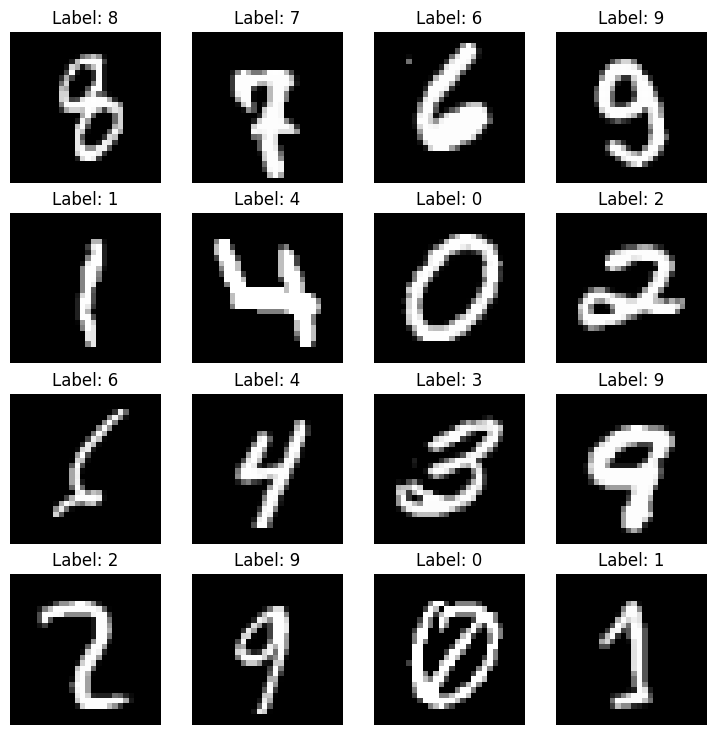

In [5]:
# Plot some data
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(dim=0), cmap='gray')  # Squeeze to remove the channel dimension for grayscale images
    plt.title(f"Label: {label}")  # Show the label as title
    plt.axis(False)

In [6]:
from torch.utils.data import DataLoader

# create hyper paramiter for batch size
BATCHSIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCHSIZE,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCHSIZE,
                             shuffle=False)



In [7]:
### size of image
print(train_data[0][0].shape)

torch.Size([1, 28, 28])


In [8]:
### setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
import requests
from pathlib import Path

# Download helper fun from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_function allredy exist and skip download")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [10]:
from torch import nn
from tqdm.auto import tqdm

### Linear Model

class NumberClasyfication_Linear(nn.Module):
  def __init__(self, input_shape, hidden_unit, output_shape):
    super().__init__()
    self.layer_stock = nn.Sequential(
                       nn.Flatten(),
                       nn.Linear(in_features=input_shape,
                                 out_features=hidden_unit),
                       nn.Linear(in_features=hidden_unit,
                                 out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stock(x)

In [11]:
### NonLinear Model

class NumberClasyfication_NonLinear(nn.Module):
  def __init__(self, input_shape, hidden_unit, output_shape):
    super().__init__()
    self.layer_stock = nn.Sequential(
                       nn.Flatten(),
                       nn.Linear(in_features=input_shape,
                                 out_features=hidden_unit),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden_unit,
                                 out_features=output_shape),
                       nn.ReLU()

    )

  def forward(self, x: torch.Tensor) -> torch.Tensor():
    return self.layer_stock(x)

In [12]:
### Convolution Model (CNN)
class NumberClasyfication_CNN(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_unit: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
                        # Create a convolution layer
                        nn.Conv2d(in_channels=input_shape,
                                  out_channels=hidden_unit,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=hidden_unit,
                                  out_channels=hidden_unit,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
                        nn.Conv2d(in_channels=hidden_unit,
                                  out_channels=hidden_unit,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=hidden_unit,
                                  out_channels=hidden_unit,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.MaxPool2d(kernel_size=2)

    )
    self.classyfier = nn.Sequential(
                      nn.Flatten(),
                      nn.Linear(in_features=hidden_unit*7*7,
                                out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x)
    x = self.classyfier(x)

    return x

In [13]:
torch.manual_seed(42)
CNN_model = NumberClasyfication_CNN(input_shape=1,
                              hidden_unit=10,
                              output_shape=len(class_name)).to(device)

shape of img: torch.Size([1, 28, 28])
tensor([8])


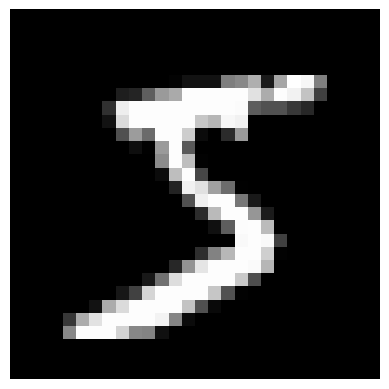

In [14]:
# cheak the size of the hidden unit
img = train_data[0][0]
print(f"shape of img: {img.shape}")
plt.imshow(img.squeeze(dim=0), cmap='gray')
plt.axis(False)
print(CNN_model(img.unsqueeze(dim=0)).argmax(dim=1))


In [15]:
### testing model function

torch.manual_seed(42)

def eval_model(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(data_loader):
            # Move data to device
            X, y = X.to(device), y.to(device)

            # Make prediction
            y_pred = model(X)

            # Calculate loss and accuracy
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Average loss and accuracy
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}

In [16]:
### Function for time compilation
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Print difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f}")
  return total_time

In [17]:
### Tran step
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimmizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
  model = model.to(device)
  ### traiing mode
  model.train()
  # Loop on data (batches)
  for batch, (X, y) in tqdm(enumerate(data_loader)):
    train_loss, train_acc = 0, 0
    # mova data to device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred = model(X)
    # Calcualte a loss and acc
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += acc_fn(y_true=y,
                        y_pred=y_pred.argmax(dim=1))
    # gradient decent
    optimmizer.zero_grad()
    # bacward propagation
    loss.backward()
    # update
    optimmizer.step()
    # print result
    if batch % 400 == 0:
      print(f"Looked at: {batch*len(X)}/{len(data_loader.dataset)}")

  # divide loss and acc per len of data
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"train loss: {train_loss:.5f} | acc loss: {train_acc:.2f}")

In [18]:
### Test step
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              acc_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  # turn off gradient decent
  with torch.inference_mode():
    for test_X, test_y in data_loader:
      # Move data to device
      test_X, test_y = test_X.to(device), test_y.to(device)
      # Forward pass
      test_pred = model(test_X)
      # calualte a loss/acc
      test_loss += loss_fn(test_pred, test_y)
      test_acc += acc_fn(y_true=test_y,
                         y_pred=test_pred.argmax(dim=1))

    # divide loss and acc per len of data
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"test loss: {test_loss:.5f} | acc lose: {test_acc:.2f}")


In [19]:
### Testing loop for Liner model
linear_model = NumberClasyfication_Linear(input_shape=28*28,
                                          hidden_unit=10,
                                          output_shape=len(class_name))
# define loss fun and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=linear_model.parameters(),
                             lr=0.01)

# define epochs number
epochs = 3

start_linear_model = timer()
for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}\n------------")
  train_step(model=linear_model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimmizer=optimizer,
             acc_fn=accuracy_fn,
             device='cuda' if torch.cuda.is_available() else 'cpu')
  test_step(model=linear_model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            acc_fn=accuracy_fn,
            device='cuda' if torch.cuda.is_available() else 'cpu')
stop_linear_model = timer()

time_of_learn_lianer_model = print_train_time(start=start_linear_model,
                                              end=stop_linear_model,
                                              device='cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00004 | acc loss: 0.05
test loss: 0.44469 | acc lose: 87.32
epoch: 1
------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00004 | acc loss: 0.05
test loss: 0.42939 | acc lose: 87.96
epoch: 2
------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00004 | acc loss: 0.05
test loss: 0.42884 | acc lose: 88.39
Train time on cpu: 48.592


In [20]:
### Train loop for NonLinear Model
nonlinear_model = NumberClasyfication_NonLinear(input_shape=28*28,
                                                hidden_unit=10,
                                                output_shape=len(class_name))

# define loss and acc and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=nonlinear_model.parameters(),
                             lr = 0.01)

# define epochs number
epochs = 3

start_nonlinear_model = timer()
for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}\n----------------")
  train_step(model=nonlinear_model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimmizer=optimizer,
            acc_fn=accuracy_fn,
            device='cuda' if torch.cuda.is_available() else 'cpu')
  test_step(model=nonlinear_model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            acc_fn=accuracy_fn,
            device='cuda' if torch.cuda.is_available() else 'cpu')
stop_nonlinear_model = timer()

time_of_learn_nonlianer_model = print_train_time(start=start_nonlinear_model,
                                              end=stop_nonlinear_model,
                                              device='cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
----------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00010 | acc loss: 0.05
test loss: 0.36058 | acc lose: 89.92
epoch: 1
----------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00004 | acc loss: 0.05
test loss: 0.35136 | acc lose: 90.23
epoch: 2
----------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00005 | acc loss: 0.05
test loss: 0.31509 | acc lose: 91.26
Train time on cpu: 41.482


In [21]:
### Testing loop for convolution NN

torch.manual_seed(42)
epochs = 3

# setup loss, opti  and acc
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CNN_model.parameters(),
                             lr=0.01)
accuracy_fn = accuracy_fn

start_CNN = timer()

for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}\n----------------")
  train_step(model=CNN_model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimmizer=optimizer,
            acc_fn=accuracy_fn,
            device='cuda' if torch.cuda.is_available() else 'cpu')
  test_step(model=CNN_model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            acc_fn=accuracy_fn,
            device='cuda' if torch.cuda.is_available() else 'cpu')

stop_CNN = timer()
time_of_learn_CNN_model = print_train_time(start=start_CNN,
                                              end=stop_CNN,
                                              device='cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
----------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00000 | acc loss: 0.05
test loss: 0.10703 | acc lose: 96.40
epoch: 1
----------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00001 | acc loss: 0.05
test loss: 0.10255 | acc lose: 96.59
epoch: 2
----------------


0it [00:00, ?it/s]

Looked at: 0/60000
Looked at: 12800/60000
Looked at: 25600/60000
Looked at: 38400/60000
Looked at: 51200/60000
train loss: 0.00003 | acc loss: 0.05
test loss: 0.15627 | acc lose: 94.81
Train time on cpu: 180.971


In [22]:
linear_result = eval_model(model=linear_model,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)

nonlinear_result = eval_model(model=nonlinear_model,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)

CNN_result = eval_model(model=CNN_model,
                        data_loader=test_dataloader,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [23]:
import pandas as pd
compare_results = pd.DataFrame([linear_result,
                               nonlinear_result,
                                CNN_result])
compare_results["train time"] = [time_of_learn_lianer_model,
                                 time_of_learn_nonlianer_model,
                                 time_of_learn_CNN_model]

compare_results

,model_name,model_loss,model_acc,train time
0,NumberClasyfication_Linear,0.428844,88.388578,48.592272
1,NumberClasyfication_NonLinear,0.315091,91.263978,41.481917
2,NumberClasyfication_CNN,0.156266,94.808307,180.971082


In [24]:
# Make and evaluiate random predictions with best model
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepere the smaples (add bache dim and pass to the traget device)
      sample = sample.unsqueeze(dim=0).to(device)

      # forward pass
      pred_logits = model(sample)

      # Get predictions propabilitis (raw logits -> predict propability)
      pred_prob = pred_logits.squeeze(dim=0).softmax(dim=0)

      # Get pred_prob off GPU
      pred_probs.append(pred_prob.to('cpu'))

    return torch.stack(pred_probs)


torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

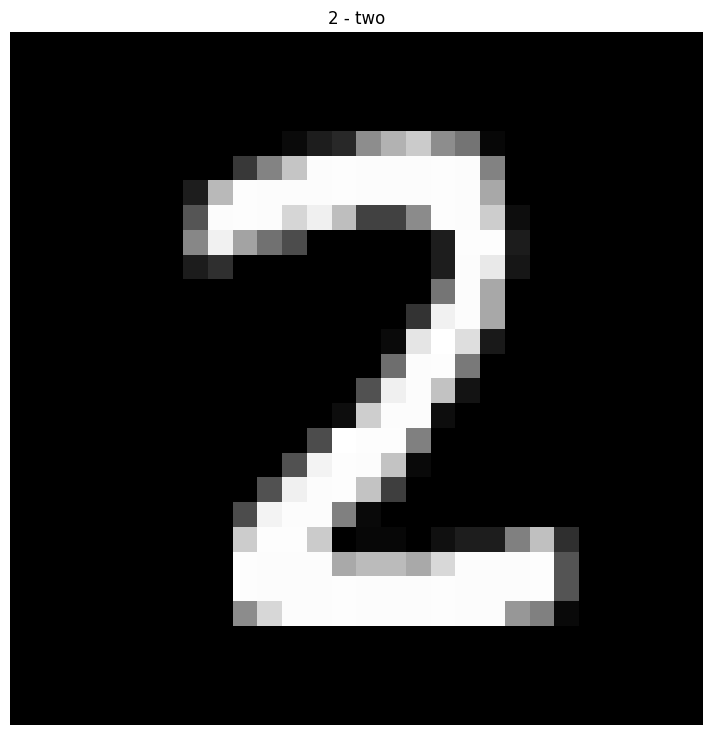

In [25]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(test_samples[0].shape)
fig = plt.figure(figsize=(9, 9))
plt.imshow(test_samples[0].squeeze(dim=0), cmap='gray')
plt.title(class_name[test_labels[0]])
plt.axis(False)

In [26]:
# Make predictions
pred_probs = make_predictions(model=CNN_model,
                             data=test_samples)

print(pred_probs[:2])

pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)

tensor([[5.2748e-06, 3.8072e-05, 9.9884e-01, 4.8297e-04, 5.8595e-08, 5.1269e-10,
         8.0738e-09, 3.4583e-04, 2.8604e-04, 2.0383e-06],
        [4.7186e-04, 9.6725e-01, 7.0680e-03, 3.0886e-04, 5.4216e-03, 5.2725e-03,
         3.6661e-03, 1.1920e-03, 9.0804e-03, 2.7085e-04]])
tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])


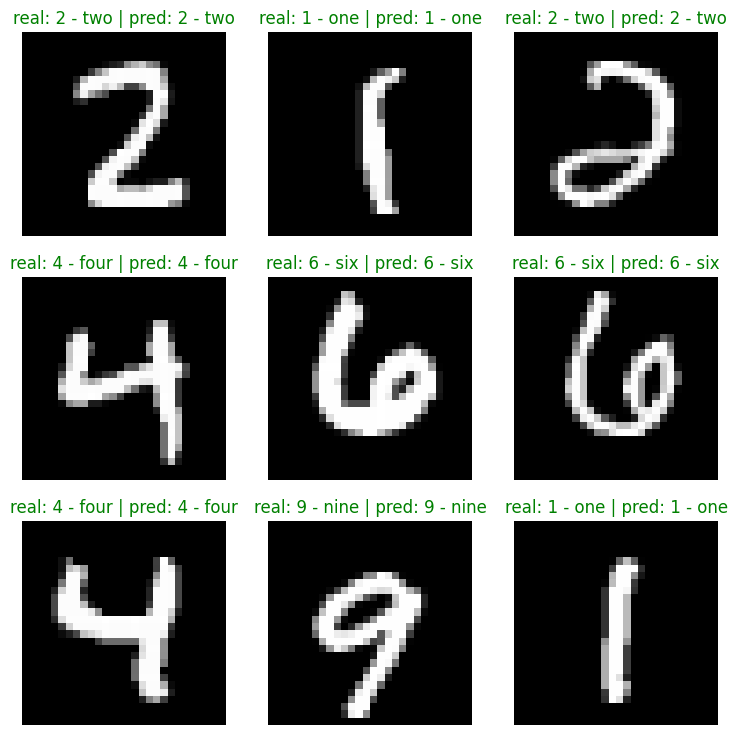

In [27]:
# plot result
fig = plt.figure(figsize=(9, 9))
cols, rows = 3, 3

for i in range(len(test_samples)):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(test_samples[i].permute(1, 2, 0), cmap='gray')

  if test_labels[i] == pred_classes[i]:
    title_color='green'
  else:
    title_color='red'

  plt.title(f"real: {class_name[test_labels[i]]} | pred: {class_name[pred_classes[i]]}", color=title_color)

  plt.axis(False)